<a href="https://colab.research.google.com/github/hikmatfarhat-ndu/pytorch/blob/main/detecting-emotions-pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What you will learn
1. Using Kaggle and importing Kaggle datasets
1. Reading a dataset of images using ImageFolder
1. Using Dropout to reduce overfitting

In [1]:
import torch
import torch.nn as nn
import torchvision as vision
from torchvision.transforms import Lambda,Compose,ToTensor,Normalize,Grayscale,ToPILImage
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

## The data
The data is stored on Kaggle. If you are running this notebook on 
1. Kaggle do the following
    1. Using the right panel click on "Add Data"
    1. Use the search keywords "manas sambare fer-2013"
    1. Click on the "+"
    1. The data is accessible from "/kaggle/input/fer2013" (see below)
1. Google Colab do the following:
    1. Go to your Kaggle account and click on your profile
    1. Click on "Account"
    1. Toward the middle of the page click on "Create new API token"
    1. A file "kaggle.json" will be downloaded. Remember where it was saved

## If you are running on Kaggle

In [ ]:
#transform=Compose([Grayscale(),ToTensor(),Normalize(0.5,0.5)])
transform=Compose([Grayscale(),ToTensor()])
dataset_train=datasets.ImageFolder("/kaggle/input/fer2013/train",transform=transform)
dataset_test=datasets.ImageFolder("/kaggle/input/fer2013/test",transform=transform)


## If you are running on Colab

In [2]:
from google.colab import files
file=files.upload()
!mkdir /root/.kaggle
!mv kaggle.json  /root/.kaggle
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip>/dev/null
transform=Compose([Grayscale(),ToTensor()])
dataset_train=datasets.ImageFolder("train",transform=transform)
dataset_test=datasets.ImageFolder("test",transform=transform)


Saving kaggle.json to kaggle.json
 81% 49.0M/60.3M [00:01<00:00, 36.6MB/s]
100% 60.3M/60.3M [00:01<00:00, 48.0MB/s]


In [3]:
print("There are {} samples each with the following categories \n {}".format(
      len(dataset_train),dataset_train.classes))

There are 28709 samples each with the following categories 
 ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


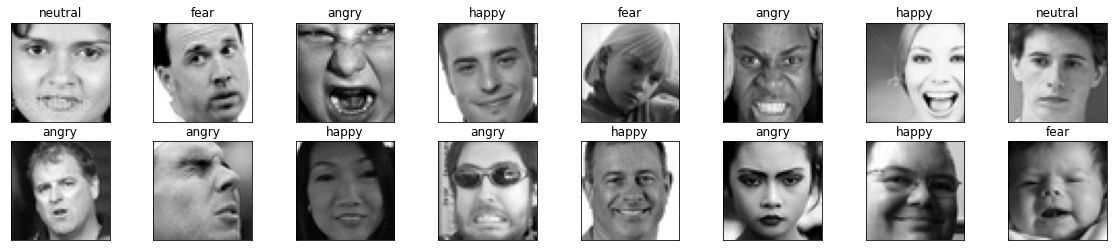

In [4]:


import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
fig.tight_layout()
#plt.subplots_adjust( wspace=1, hspace=1)
to_image=ToPILImage()
for i in range(16):
            idx=torch.randint(len(dataset_test),size=(1,)).item()
            img,label=dataset_test[idx]
            t=fig.add_subplot(2,8,i+1)
            # set the title of the image equal to its label
            t.set_title(dataset_test.classes[label])
            t.axes.get_xaxis().set_visible(False)
            t.axes.get_yaxis().set_visible(False)
            plt.imshow(to_image(img),cmap='gray')

In [5]:
train_loader=DataLoader(dataset_train,batch_size=64,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(dataset_test,batch_size=64,shuffle=False,num_workers=2,pin_memory=True)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu=nn.ReLU()
        self.flatten=nn.Flatten()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3)
        self.conv2=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3)
        self.pool1=nn.MaxPool2d(kernel_size=2)
        self.drop1=nn.Dropout()
        self.conv3=nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3)
        self.conv4=nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3)
        self.pool2=nn.MaxPool2d(kernel_size=2)
        self.drop2=nn.Dropout()
        self.fc1=nn.Linear(in_features=9*9*256,out_features=1024)
        self.drop3=nn.Dropout()
        self.fc2=nn.Linear(in_features=1024,out_features=7)
    def forward(self,x):
        #input (1,48,48)
        x=self.conv1(x)
        x=self.relu(x)
        #input (32,46,46)
        x=self.conv2(x)
        x=self.relu(x)
        #input (64,44,44)
        x=self.pool1(x)
        x=self.drop1(x)
        
        #input (64,22,22)
        x=self.conv3(x)
        x=self.relu(x)
        #input (128,20,20)
        x=self.conv4(x)
        x=self.relu(x)
        #input (256,18,18)
        x=self.pool2(x)
        x=self.drop2(x)
        #input (256,9,9)
        x=self.flatten(x)
        x=self.fc1(x)
        x=self.relu(x)
        x=self.drop3(x)
        x=self.fc2(x)
        return x

In [8]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m,nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.0)
model=Net()
#model=model.cuda()
#model.apply(init_weights)

In [ ]:
%%time
import torch.optim as optim
loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters())
from tqdm import tqdm
epochs=10

for epoch in range(epochs):
    print(f"epoch {epoch}:",end=' ')
    train_loader=tqdm(train_loader)
    epoch_loss=0.0
    for imgs,labels in train_loader:
        #imgs=imgs.cuda()
        #labels=labels.cuda()
        outputs=model(imgs)
        optimizer.zero_grad()
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    print(epoch_loss)
    
        

In [ ]:
# save the model to a file
torch.save(model,'model.h5')

In [ ]:
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
conmat=ConfusionMatrix(num_classes=7)
conmat=conmat.cuda()

In [ ]:
# load the model from the file
model=torch.load('model.h5')
total=len(dataset_test)
correct=0
for imgs,labels in test_loader:
    imgs=imgs.cuda()
    labels=labels.cuda()
    outputs=model(imgs)
    _,predicted=torch.max(outputs.data,1)
    tmp=(predicted==labels).sum()
    correct+=tmp
    conmat.update(predicted,labels)
print(correct/total)

tensor(0.5387, device='cuda:0')


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb

<AxesSubplot:>

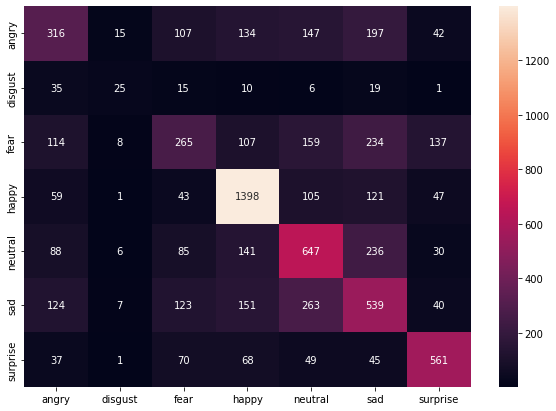

In [ ]:
x=conmat.compute().cpu().numpy()
plt.figure(figsize=(10,7))
sb.heatmap(x,xticklabels=dataset_train.classes,yticklabels=dataset_train.classes,annot=True,fmt=".0f")